In [3]:
import numpy as np
import pandas as pd
import numpy.linalg as la

$$ P(x, t | \tau) = P(x| t, \tau)P(t | \tau) $$

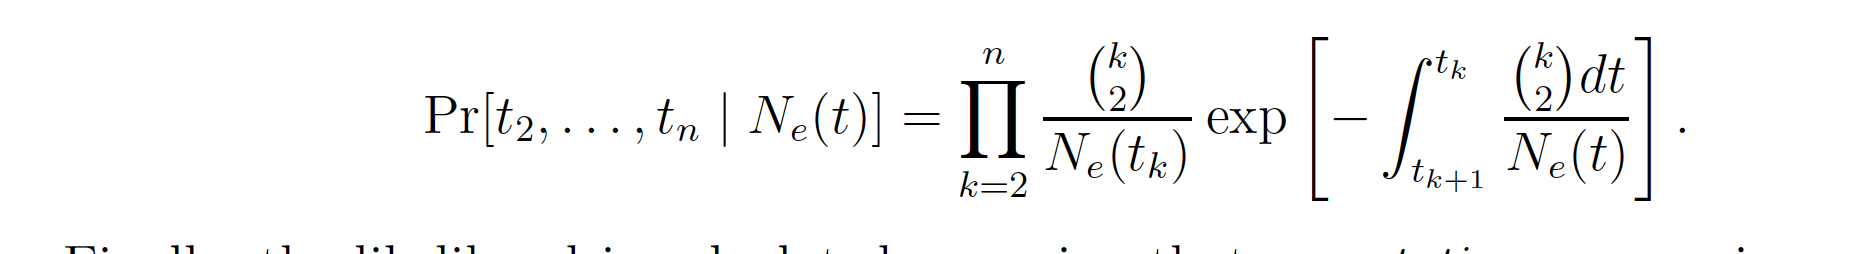


n: number of leaves

coalescent_times should from 0 to tn, tn-1, ..., t2,
tk: the time that number of coalescents decreases from k to k -1

t2 is the largest, tk is the smallest
t2,...,tk



In [138]:
1/(kchoose2(2)/10), 1/(kchoose2(3)/10), 1/(kchoose2(4)/10)

(10.0, 3.3333333333333335, 1.6666666666666667)

distribution of t is exponential


hence p(t) is exponential(lambda_)

q(t) should be exponential(lambda_2)

In [172]:
def prior_coalescent(coalescent_times, Ne):
    
    ###########lambdas have already been fixed
    ld_true = [kchoose2(i+2)/Ne for i in range(len(coalescent_times))]
    prior = q_coalescent_time_prior(coalescent_times, ld_true)
    
    return prior


def pxtgiventau(likelihood, coalescent_times, Ne):

    prior = prior_coalescent(coalescent_times, Ne)
    return prior*likelihood
    
    
###model delta_x as exponential distribution
def exponential_distribution(lambda_, t):
    return lambda_ * np.exp(-lambda_ * t)
    
    #####assume that each delta t distribution based on the formula above
    
def kchoose2(k):
    if k == 1:
        return 1
    else:
        return k*(k-1)/2
    
def q_coalescent_time_prior(coalescent_times, lambdas_):
    
    #####coalescent_times: large to small, q[0] represents deltat[0]
    
    time_diff = []
    for i in range(len(coalescent_times) - 1):
        time_diff.append(coalescent_times[i] - coalescent_times[i+1])
        
    time_diff.append(coalescent_times[-1])
    q = 1
    for i in range(len(time_diff)):
        q = q*exponential_distribution(lambdas_[i], time_diff[i])
    return q







In [97]:
coalescent_times = [4,3.5,2]
time_diff = []
for i in range(len(coalescent_times) - 1):
    time_diff.append(coalescent_times[i] - coalescent_times[i+1])

time_diff.append(coalescent_times[-1])
time_diff
ld_true = [.7,1.3,1.7]
ld_true = [1,1,1]
q_coalescent_time_prior(coalescent_times, ld_true)
ld_true = [1/.7,1/1.3,1/1.8]
q_coalescent_time_prior(coalescent_times, ld_true)

[0.5, 1.5, 2]
[0.5, 1.5, 2]


0.03103253947027161

In [160]:
[kchoose2(2)/3, kchoose2(3)/3, kchoose2(4)/3]

[0.3333333333333333, 1.0, 2.0]

In [349]:
def black_box_vi(states, Ne, n, test = False):
    
    
    
    log_lr = []

    lambdas_ = np.ones(n)
#     coalescent_times = [4,3.5,2]
#     ld_true = [1/.7, 1/1.3, 1/1.8]
    ld_true = [kchoose2(2)/Ne, kchoose2(3)/Ne, kchoose2(4)/Ne]
    for k in range(1000):
        total_grad = 0
        gap = 0
        for i in range(50):

            zs = [] ####simulated coalescent times
            for j in range(len(lambdas_)):
                z = np.random.exponential(scale = lambdas_[j])
                zs.append(z)
            zs = np.array(zs)
            c_time = np.cumsum(zs[::-1])[::-1] ####large to small
            l_ = likelihood(states, len(states), c_time[::-1])

#             pxz = prior_coalescent(c_time, Ne)

            pxz = pxtgiventau(l_, c_time, Ne)
            if test:
                pxz = prior_coalescent(c_time, Ne)

#             pxz = q_coalescent_time_prior(c_time, ld_true)
            pq = q_coalescent_time_prior(c_time, lambdas_)
            log_pxz, log_pq = np.log(pxz), np.log(pq)
            gap += log_pxz - log_pq
            grad = (1/lambdas_ - zs)
            total_sc_grad = grad*(log_pxz - log_pq)
            total_grad += total_sc_grad
        total_grad /=50
        gap /= 50
        log_lr.append(gap)
        new_lambdas_ = lambdas_ + r_m_sequence(k)/1.5*total_grad ###log lambda ###hamiltonian monte carlo ##use log
        lambdas_ = (new_lambdas_ > 0) * new_lambdas_ + 1 *(new_lambdas_ <= 0) ###stabilizer
        
    return lambdas_, log_lr
        
        

def r_m_sequence(t, tau = .99, kappa= -1):
    return (t+tau)**kappa


def compute_likelihood(states, site, subroot, coalescent_times):

    left_child, right_child = states[subroot-1][0], states[subroot-1][1]
    left_child_likelihood, right_child_likelihood = 0,0
    left_t, right_t = -1,-1
    
    
    if type(left_child) not in [int, float]:
        init_state = np.zeros(4)
        init_state[mmap[left_child]] = 1
        left_child_likelihood = init_state
        left_t = coalescent_times[subroot-1]
    
    else:   
        left_child_likelihood = compute_likelihood(states, site, left_child, coalescent_times)
        left_t = coalescent_times[subroot-1] - coalescent_times[left_child-1] 
        
    if type(right_child) not in [int, float]:
        init_state = np.zeros(4)
        init_state[mmap[right_child]] = 1
        right_t = coalescent_times[subroot-1]
        right_child_likelihood = init_state
        
        ###gradient corresponding to coalescent time?
        ###have the
    else:
        
        right_child_likelihood = compute_likelihood(states, site, right_child, coalescent_times)
        right_t = coalescent_times[subroot-1] - coalescent_times[right_child-1]   
    likelihood = (Pij(left_t, evecs, evals, evec_inv)@left_child_likelihood) *\
    (Pij(right_t, evecs, evals, evec_inv)@right_child_likelihood)
    return likelihood

def likelihood(states, root, coalescent_times):
    
    """
    root is the number of leaves - 1
    
    """
    likelihood_vec = compute_likelihood(states, 0, root, coalescent_times)
    final_likelihood = 0.25*np.sum(likelihood_vec)
    return final_likelihood

def Pij(t, evecs, evals, evec_inv):
    return evecs@np.diag(np.exp(evals*t))@evec_inv

In [350]:
n = 3
states = [['A', 'A'],['C', 'T'], [1, 2]]
mmap = {'A':0, 'C':1, 'G':2, 'T':3}
q = np.ones((4,4))/3
for i in range(4):
    q[i,i]= -1
evals, evecs = la.eig(q)
evec_inv = la.inv(evecs)
lb_test = black_box_vi(states, 3, len(states), test = True)

In [351]:
lb_test[0]

array([0.33333462, 1.00055903, 2.0000002 ])

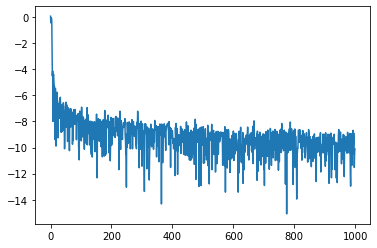

In [353]:
plt.plot(np.log(np.abs(lb_test[1])))

### converging to the exact parameters from the ground truth $p(x,z)$

In [ ]:
n = 3
# states = [['C', 'C'],['A', 'G'], ['T', 1], ['T', 2], ['A', 4], [3,5], ['A', 6]]
# coalescent_times = [.15, .6, 2]
states = [['A', 'A'],['C', 'T'], [1, 2]]
mmap = {'A':0, 'C':1, 'G':2, 'T':3}
q = np.ones((4,4))/3
for i in range(4):
    q[i,i]= -1
evals, evecs = la.eig(q)
evec_inv = la.inv(evecs)
lbs = black_box_vi(states, 3, len(states))



Text(0.5, 1.0, 'variational inference elbo')

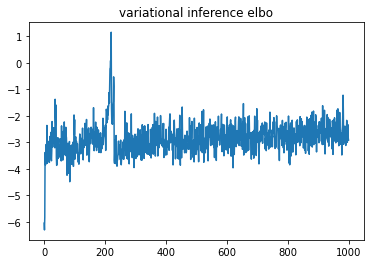

In [217]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(lbs[1][:1000])
plt.title("variational inference elbo")

Text(0.5, 1.0, 'smoothed loss log function')

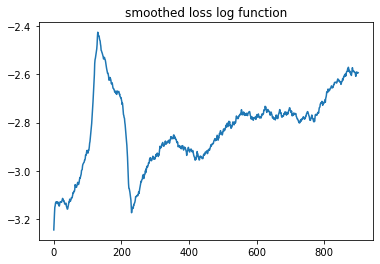

In [288]:
plt.plot(np.convolve(lbs[1], np.ones(100)/100, mode='valid'))
plt.title("smoothed loss log function")
# np.convolve()

#### The gap decreases between the variational approximation and ground truth

In [235]:
delta_time_expected = [1/ 0.57421784, 1/1.84004883, 1/2.89213059][::-1]
delta_time_expected

[0.3457658528482976, 0.5434638384025928, 1.7414993585012963]

In [242]:
likelihood(states, 3, np.cumsum(time_expected))


0.007751163895750993

In [237]:
np.cumsum(delta_time_expected)

array([0.34576585, 0.88922969, 2.63072905])

In [259]:
l_ = 0
for l in range(1000):
    k = np.random.exponential(size = 3)
    l_ += likelihood(states, 3, np.cumsum(k))
l_/1000

0.005966592164283249

In [257]:
np.cumsum(k)

array([1.69579186, 1.72592274, 3.21075944])

In [312]:
states = [['A', 'A'],['C', 'T'], [1, 2]]
mmap = {'A':0, 'C':1, 'G':2, 'T':3}
q = np.ones((4,4))/3
for i in range(4):
    q[i,i]= -1
evals, evecs = la.eig(q)
evec_inv = la.inv(evecs)
lbs2 = black_box_vi(states, 3, len(states))

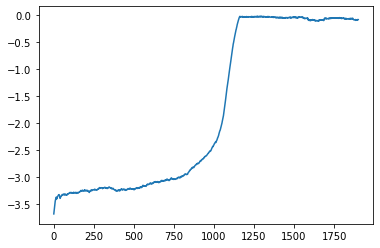

In [313]:
plt.plot(np.convolve(lbs2[1], np.ones(100)/100, mode='valid'))

In [328]:
# lbs2[0],
# sennheiser
# np.cumsum((1/lbs2[0])[::-1])
lbs2[0]

array([0.00728964, 0.89994879, 2.63112931])

In [324]:
likelihood(states, 3, np.array([0.1,2,3]))

0.012810633226919416

In [315]:
# likelihood((1/lbs2[0])[::-1]
likelihood(states, 3, np.cumsum((1/lbs2[0])[::-1]))

0.008006522011522469

In [327]:
states = [['C', 'C'],['A', 'G'], ['T', 1], ['T', 2], ['A', 4], [3,5], ['A', 6]]

mmap = {'A':0, 'C':1, 'G':2, 'T':3}
q = np.ones((4,4))/3
for i in range(4):
    q[i,i]= -1
evals, evecs = la.eig(q)
evec_inv = la.inv(evecs)
lbs3 = black_box_vi(states, 7, len(states))

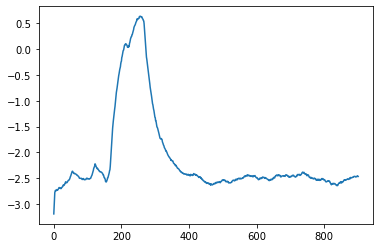

In [329]:
plt.plot(np.convolve(lbs3[1], np.ones(100)/100, mode='valid'))

In [336]:
likelihood(states, 7, np.array([.05,2,3,4,5,6,7]))

5.503189302910339e-05

In [337]:
states

[['C', 'C'], ['A', 'G'], ['T', 1], ['T', 2], ['A', 4], [3, 5], ['A', 6]]

In [333]:
likelihood(states, 7, np.cumsum((1/lbs3[0])[::-1]))

2.4851702972044138e-05

### exponential prior topology
### population trajectory prior on the coalescent time

### I already had likelihood partially labelled

#### 1. plug in log(likelihood * prior topology* prior coalescent)
#### 2. q only needs to approximate the prior coalescent time
#### 3. q can be product of n indepdent exponential distribution
#### 4. take gradient of q from each lambda from n indepdent exponential distribution

rate of coalescent, branch length time informed by data
Ne is a function of the coalescent time, weight on the prior of the branch length. assume it is a constant function, do variational infernece, people only use the information from mutation. 
recalibration method,

$$ \exp(-\lambda t)$$
$$-\lambda t$$

$$p(topology | time, Ne) * p(time | Ne) * p( Ne)$$

z = t,
continous relaxation



$$p($$

In [12]:
from math import factorial
import numpy as np

states = [['A', 'A'],['C', 'T'], [1, 2]]
mmap = {'A':0, 'C':1, 'G':2, 'T':3}
def construct_F_matrix(states):
    F_mat = np.zeros((len(states), len(states)))
    
    n = len(states)
    
    #########update diagonals##################
    for i in range(F_mat.shape[0]):
        F_mat[i,i] = i+2
    subtraction_time = {i:0 for i in range(F_mat.shape[0])}
    #########update off-diagonal###############
    for j in range(F_mat.shape[0]):
        start_val = F_mat[j,j]
        left_child, right_child = states[n-1-j]
        if type(left_child) in [int, float]:
            subtraction_time[n - left_child] -= 1
        if type(right_child) in [int, float]:
            subtraction_time[n - right_child] -= 1
        for i in range(j+1, F_mat.shape[0]):
            F_mat[i,j] = F_mat[i-1,j] + subtraction_time[i]
            
    return F_mat

F_mat = construct_F_matrix(states)
        

    
def get_labels(states):
    dict_ = {}
    labels = []
    for level in states:
        left, right = level[0], level[1]
        if type(left) not in [int, float]:
            labels.append(left)
            if left not in dict_:
                dict_[left] = 1
            else:
                dict_[left] += 1
                
        if type(right) not in [int, float]:
            labels.append(right)
            if right not in dict_:
                dict_[right] = 1
            else:
                dict_[right] += 1
                
    return dict_, labels
            
    
def compute_num_partially_labelled_trees(states):
    dict_, labels = get_labels(states)
    num_two_children = 0
    for level in states:
        if (type(level[0]) not in [int, float]) and (type(level[1]) not in [int, float]):
            num_two_children += 1
    return compute_num_partailly_labelled_trees_recurse(states, num_two_children, dict_)

def compute_num_partailly_labelled_trees_recurse(states, num_two_children, dict_):

    result = 0
    if num_two_children == 0:
        cts = []
        tots = 0
        for label in dict_:
            tots += dict_[label]
            cts.append(dict_[label])
            
        result = factorial(tots)
        for ct in cts:
            result = result/factorial(ct)
        return result
    else:
        uniques = list(dict_.keys())
        for i in range(len(uniques)):
            label1 = uniques[i]
            if dict_[label1] >= 2:
                dict_[label1] -= 2
                if dict_[label1] <= 0:
                    dict_.pop(label1, None)
                result_dup = compute_num_partailly_labelled_trees_recurse(states, num_two_children - 1, dict_)
                result = result + result_dup
                if label1 not in dict_:
                    dict_[label1] = 0
                dict_[label1] += 2
                
            for j in range(i+1, len(uniques)):
                label1, label2 = uniques[i], uniques[j]
                dict_[label1] -= 1
                dict_[label2] -= 1
                if dict_[label1] <= 0:
                    dict_.pop(label1, None)
                if dict_[label2] <= 0:
                    dict_.pop(label2, None)
                result_nodup = compute_num_partailly_labelled_trees_recurse(states, num_two_children - 1, dict_)
                result = result + result_nodup
                if label1 not in dict_:
                    dict_[label1] = 0
                if label2 not in dict_:
                    dict_[label2] = 0
                dict_[label1] += 1
                dict_[label2] += 1
                
        return result

In [6]:
states = [['a', 'b'],['b', 1],['a', 2],['c',3]]
# get_labels(states)
# # F_mat = construct_F_matrix(states)
# # F_mat

compute_num_partially_labelled_trees(states)

18.0

In [10]:
states
compute_num_partially_labelled_trees(states)

18.0

In [7]:
states = [['l1', 'l2'],[1, 'l3'],['l4', 'l5'],[2,3]]
F_mat = construct_F_matrix(states)
F_mat

array([[2., 0., 0., 0.],
       [1., 3., 0., 0.],
       [0., 2., 4., 0.],
       [0., 2., 3., 5.]])

In [27]:
states = [['l4', 'l5'],['l1','l2'],[2, 'l3'],[1,3]]
F_mat = construct_F_matrix(states)
F_mat

array([[2., 0., 0., 0.],
       [1., 3., 0., 0.],
       [1., 2., 4., 0.],
       [0., 1., 3., 5.]])

In [28]:
states = [['l2', 'l3'],['l4','l5'],[1, 2],['l1',3]]
F_mat = construct_F_matrix(states)
F_mat

array([[2., 0., 0., 0.],
       [1., 3., 0., 0.],
       [1., 2., 4., 0.],
       [1., 1., 3., 5.]])

In [35]:
len(states)

7

In [40]:
def F_mat_to_float(F_mat):

    k = np.array([.2,.7,-.5,1.9, .9,-1.2,-1.3])
    k2 = np.array([.3, -.5, .6, .8,-1,-3,2])
    k3 = np.array([-2, .3, -1,-.5, 2,.3,.5])
    return np.mean((F_mat@k)**2 + (F_mat@k2)**2 + (F_mat@k3)**3)

#### Need to use the prior for partially labelled trees instead of unlabelled tree

In [8]:
def compute_stationary_probability(states):
    ####aabb: 0, aabc: 0,aaba: 1/2, abca,  abab
    stationary_prob = 0
    for i in range(1, len(states)):
        s1, s2, s3, s4 = states[i-1][0], states[i-1][1], states[i][0], states[i][1]
        c1 = s1 == s3
        c2 = s1 == s4
        c3 = s2 == s3
        c4 = s2 == s4
        prob = (c1 + c2 + c3 +c4)/4
        stationary_prob += prob*1/(len(states)-1)
        
    return stationary_prob
        
        

In [19]:
states = [['C', 'C'],['A', 'G'], ['T', 1], ['T', 2], ['A', 4], [3,5], ['A', 6]]
# compute_stationary_probability(states)

F_mats = []
F_mat_set = set()
for i in range(1000):
    
    flag, f, r = markov_chain_forward(len(states), states)
    if flag:
        F_mats.append(construct_F_matrix(states))

In [20]:
F_mats = np.array(F_mats)
F_mat0 = np.mean(F_mats,axis=0)

In [23]:
np.mean(np.sum((F_mats - F_mat0)**2, axis=(1,2))) ###mean distance

2.573182203096338

In [26]:
dists = np.sum((F_mats - F_mat0)**2, axis=(1,2))
sd = np.std(dists)
var = sd**2

In [28]:
beta = np.sqrt(1/var)
beta

0.8051383501409949

In [29]:
z = 1 + np.exp(-beta)

In [46]:
var

1.5426200556036336

In [43]:
F_mat_set = set()
z_true = 0
for i in range(1000):
    
    flag, f, r = markov_chain_forward(len(states), states)
    fmat = construct_F_matrix(states)
    num = F_mat_to_float(fmat)
    if num not in F_mat_set:
        z_true += np.exp(-beta * np.sum(( fmat - F_mat0)**2))
        F_mat_set.add(num)

In [44]:
z_true

8.306714275342243

In [6]:
def markov_chain_forward(n, states):
    prob, reverse_prob = 0,0
    stationary_prob = compute_stationary_probability(states)
    k = np.random.randint(low= 1, high = n-1)
    swap1 = np.random.randint(low=0, high = 2) ###output 0, 1
    swap2 = np.random.randint(low=0, high = 2) ###output 0, 1
    ##swap from left to right should be good
    ####k is original k
    #### states[k-1]: kth state, states[k]: k+1 state 
    #max k can be n-2
    status_firstchild = type(states[k][swap2]) in [int, float]
    if status_firstchild:
        status_firstchild = states[k][swap2]

    ###compute forward prob
    if status_firstchild < k:####make the swap
        if states[k-1][swap1] == states[k][swap2]:
            prob = stationary_prob
        else: 
            prob = 1/4
            ##aabc
            status_secondchild = (type(states[k][1-swap2]) in [int, float])
            if status_secondchild == 1:
                status_secondchild = states[k][1- swap2]
            if status_secondchild < k:
                if states[k][swap2] == states[k][1 - swap2]:
                    prob = prob * 2
                if states[k-1][swap1] == states[k-1][1-swap1]:
                    prob = prob * 2
            else: ###not elible to swap for 1 - swap2
                prob = 1/2
                if states[k-1][swap1] == states[k-1][1 - swap1]:
                    prob = prob * 2
            prob = prob/(n-2)

        states[k-1][swap1], states[k][swap2] = states[k][swap2], states[k-1][swap1]
        ###compute reverse prob
        if states[k-1][swap1] == states[k][swap2]:
            reverse_prob = prob
        else:
            reverse_prob = 1/4
            status_secondchild = (type(states[k][1-swap2]) in [int, float])
            if status_secondchild == 1:
                status_secondchild = states[k][1- swap2]
            if status_secondchild < k:
                if states[k][swap2] == states[k][1 - swap2]:
                    reverse_prob = reverse_prob * 2
                if states[k-1][swap1] == states[k-1][1-swap1]:
                    reverse_prob = reverse_prob * 2
            else: ###not elible to swap for 1 - swap2
                reverse_prob = 1/2
                if states[k-1][swap1] == states[k-1][1 - swap1]:
                    reverse_prob = reverse_prob * 2
            reverse_prob = reverse_prob/(n-2)
        return True, prob, reverse_prob
    else:###dont make the swap
        return False, prob, reverse_prob

        
def markov_chain_seq(n, sequence):
    k = np.random.randint(low= 1, high = n-1)
    swap1 = np.random.randint(low=0, high = 2) ###output 0, 1
    swap2 = np.random.randint(low=0, high = 2) ###output 0, 1
    state = sequence[0]
    try:
        if state[k][swap2] < k:
            for x in range(len(sequence)):
                sequence[x][k-1][swap1], sequence[x][k][swap2] =  sequence[x][k][swap2],sequence[x][k-1][swap1]
            return True
        else:
            return False
    except:
        for x in range(len(sequence)):
            sequence[x][k-1][swap1], sequence[x][k][swap2] =  sequence[x][k][swap2],sequence[x][k-1][swap1]
        return True
   

In [5]:
markov_chain_forward(len(states)+1, states)

NameError: name 'markov_chain_forward' is not defined

In [15]:
n = 3
# states = [['C', 'C'],['A', 'G'], ['T', 1], ['T', 2], ['A', 4], [3,5], ['A', 6]]
coalescent_times = [.15, .6, 2]
states = [['A', 'A'],['C', 'T'], [1, 2]]
mmap = {'A':0, 'C':1, 'G':2, 'T':3}
q = np.ones((4,4))/3
for i in range(4):
    q[i,i]= -1
evals, evecs = la.eig(q)
evec_inv = la.inv(evecs)

states

[['A', 'A'], ['C', 'T'], [1, 2]]

### Validation on the likelihood Computation

In [ ]:
l = []
simulations = []
from copy import deepcopy
for i in range(50):
    states[0][0] = np.random.choice(['A','C','G','T'])
    states[0][1] = np.random.choice(['A','C','G','T'])
    states[1][0] = np.random.choice(['A','C','G','T'])
    states[1][1] = np.random.choice(['A','C','G','T'])
    
    print(i, 'loop')
    print(states)
    s = deepcopy(states)
    l.append(likelihood(s, 3))
    p = 0
    for j in range(100000):
        if j %20000 == 0:
            print(j//20000, 'iter')
        p += mc_probability(s, coalescent_times)[0]
    simulations.append(p/100000)
#         markov_chain_forward(n, states)
    

In [145]:
l = np.array(l)

In [146]:
simulations = np.array(simulations)

Text(0,0.5,'simulated monte carlo probability')

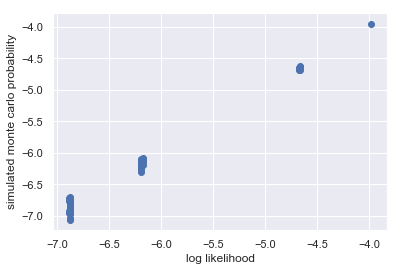

In [191]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(np.log(l), np.log(simulations))
plt.xlabel('log likelihood')
plt.ylabel('simulated monte carlo probability')

In [192]:
import numpy as np
np.corrcoef(np.log(l), np.log(simulations))

array([[1.        , 0.99583784],
       [0.99583784, 1.        ]])

In [193]:
r_squared = 1 - np.sum((np.array(l) - np.array(simulations))**2)/np.sum((np.array(simulations) - np.mean(np.array(simulations)))**2)

print(r_squared, 'r_squared')

0.9983294680025736 r_squared



### accelerate likelihood computation by changing a minor part of the tree.

In [8]:
import numpy.linalg as la
def Pij(t, evecs, evals, evec_inv):
    return evecs@np.diag(np.exp(evals*t))@evec_inv
    
def mc_probability(states, coalescent_times):
    mmap = {'A':0, 'C':1, 'G':2, 'T':3}
    global labels
    labels = [1]
    root_label = np.zeros(4)
    root_label[np.random.choice([0,1,2,3])] = 1
    mc_probability_recurse(states, coalescent_times, len(states), root_label)
    return labels
       
def mc_probability_recurse(states, coalescent_times, subroot, subroot_label):
    ###simulate from subroot with a fixed label
    
    left_child, right_child = states[subroot-1][0], states[subroot-1][1]
    
    if type(left_child) not in [int, float]:
        left_time = coalescent_times[subroot-1]
        prob_left = Pij(left_time, evecs, evals, evec_inv)@subroot_label
        simulated_leaf = np.random.choice(['A','C','G','T'], p = prob_left)
        if simulated_leaf == left_child:
            labels[0] = labels[0]*1
        else:
            labels[0] = 0
        
#         labels.add(left_child)
    else:
        left_time = coalescent_times[subroot-1] - coalescent_times[left_child-1]
        prob_left = Pij(left_time, evecs, evals, evec_inv)@subroot_label
        newlabelindex = np.random.choice([0,1,2,3], p = prob_left)
        newlabel = np.array([0,0,0,0])
        newlabel[newlabelindex] = 1
        mc_probability_recurse(states, coalescent_times, left_child, newlabel)

    if type(right_child) not in [int, float]:
        right_time = coalescent_times[subroot-1]
        prob_right = Pij(right_time, evecs, evals, evec_inv)@subroot_label
        
        simulated_leaf = np.random.choice(['A','C','G','T'], p = prob_right)
        if simulated_leaf == right_child:
            labels[0] = labels[0]*1
        else:
            labels[0] = 0    
#         labels.add(left_child)
    else:
        right_time = coalescent_times[subroot-1] - coalescent_times[right_child-1]
        prob_right = Pij(right_time, evecs, evals, evec_inv)@subroot_label
        newlabelindex = np.random.choice([0,1,2,3], p = prob_right)
        newlabel = np.array([0,0,0,0])
        newlabel[newlabelindex] = 1
        mc_probability_recurse(states, coalescent_times, right_child, newlabel)
        return
        


from copy import deepcopy
def generate_data(states, coalescent_times):
    
    mmap = {'A':0, 'C':1, 'G':2, 'T':3}
    q = np.ones((4,4))/3
    for i in range(4):
        q[i,i]= -1
    evals, evecs = la.eig(q)
    evec_inv = la.inv(evecs)
    root_label = np.zeros(4)
    root_label[np.random.choice([0,1,2,3])] = 1

    generate_data_recurse(states, coalescent_times, len(states), root_label)
    
    
     
    
def generate_data_recurse(states, coalescent_times, subroot, subroot_label):
    left_child, right_child = states[subroot-1][0], states[subroot-1][1]
    if type(left_child) not in [int, float]:
        ####it is a leaf, change the state based on the sampled leaf
        left_time = coalescent_times[subroot-1]
        
        
        prob_left = Pij(left_time, evecs, evals, evec_inv)@subroot_label
        simulated_leaf = np.random.choice(['A','C','G','T'], p = prob_left)
        states[subroot-1][0] = simulated_leaf
    else:
        ###generate intermediate node
        left_time = coalescent_times[subroot-1] - coalescent_times[left_child-1]
        prob_left = Pij(left_time, evecs, evals, evec_inv)@subroot_label
        newlabelindex = np.random.choice([0,1,2,3], p = prob_left)
        newlabel = np.array([0,0,0,0])
        newlabel[newlabelindex] = 1
        generate_data_recurse(states, coalescent_times, left_child, newlabel)
        
    
    if type(right_child) not in [int, float]:
        right_time = coalescent_times[subroot-1]
        prob_right = Pij(right_time, evecs, evals, evec_inv)@subroot_label 
        simulated_leaf = np.random.choice(['A','C','G','T'], p = prob_right)
        states[subroot-1][1] = simulated_leaf
        
    else:
        right_time = coalescent_times[subroot-1] - coalescent_times[right_child-1]
        prob_right = Pij(right_time, evecs, evals, evec_inv)@subroot_label
        newlabelindex = np.random.choice([0,1,2,3], p = prob_right)
        newlabel = np.array([0,0,0,0])
        newlabel[newlabelindex] = 1
        generate_data_recurse(states, coalescent_times, right_child, newlabel)


def compute_likelihood(states, site, subroot, coalescent_times):

    left_child, right_child = states[subroot-1][0], states[subroot-1][1]
    left_child_likelihood, right_child_likelihood = 0,0
    left_t, right_t = -1,-1
    
    
    if type(left_child) not in [int, float]:
        init_state = np.zeros(4)
        init_state[mmap[left_child]] = 1
        left_child_likelihood = init_state
        left_t = coalescent_times[subroot-1]
    
    else:   
        left_child_likelihood = compute_likelihood(states, site, left_child)
        left_t = coalescent_times[subroot-1] - coalescent_times[left_child-1] 
        
    if type(right_child) not in [int, float]:
        init_state = np.zeros(4)
        init_state[mmap[right_child]] = 1
        right_t = coalescent_times[subroot-1]
        right_child_likelihood = init_state
        
        ###gradient corresponding to coalescent time?
        ###have the
    else:
        
        right_child_likelihood = compute_likelihood(states, site, right_child)
        right_t = coalescent_times[subroot-1] - coalescent_times[right_child-1]   
    likelihood = (Pij(left_t, evecs, evals, evec_inv)@left_child_likelihood) *\
    (Pij(right_t, evecs, evals, evec_inv)@right_child_likelihood)
    return likelihood

mmap = {'A':0, 'C':1, 'G':2, 'T':3}
q = np.ones((4,4))/3
for i in range(4):
    q[i,i]= -1
evals, evecs = la.eig(q)
evec_inv = la.inv(evecs)


def likelihood(states, root, coalescent_times):
    
    """
    root is the number of leaves - 1
    
    """
    likelihood_vec = compute_likelihood(states, 0, root, coalescent_times)
    final_likelihood = 0.25*np.sum(likelihood_vec)
    return final_likelihood


def seq_likelihood(sequence, n):
    l = 1
    for state in sequence:
        ll = likelihood(state, n)
        l *= ll
    return l

def compute_prior(states, fmat0):
    num_trees = compute_num_partially_labelled_trees(states)
    cur_fmat = construct_F_matrix(states)
    l2_distance = np.sum((cur_fmat - fmat0)**2)
    return 1/num_trees * np.exp(-l2_distance)

In [9]:
coalescent_times = [7.3, .5, .9]
states = [['A', 'C'],['G', 'G'], [1, 2]]
likelihood(states, 3)

0.0048501857269609506

In [84]:
import numpy as np
np.log(0.003904)

-5.545753610431291

### test whether generate data gives the correct generation

In [227]:
coalescent_times = [.2,.5,.6,.8,1.3,1.9,2.9]
states = [['G', 'G'],['C', 'A'], ['C', 1], ['C', 2], ['A', 4], [3,5], ['A', 6]]

freq = {}
for i in range(100000):
    generate_data(states, coalescent_times)
    cur_states = deepcopy(states)
    if str(cur_states) not in freq:
        freq[str(cur_states)] = 1
    else:
        freq[str(cur_states)] += 1


In [252]:
list(freq.keys())[0]

# list(freq.keys())[0].strip('][').split(', ')

"[['C', 'C'], ['G', 'G'], ['A', 1], ['C', 2], ['C', 4], [3, 5], ['G', 6]]"

In [228]:
sorted(freq.items(), key=lambda item: item[1],reverse = True)[:10]

[("[['A', 'A'], ['A', 'A'], ['A', 1], ['A', 2], ['A', 4], [3, 5], ['C', 6]]",
  43),
 ("[['G', 'G'], ['G', 'G'], ['G', 1], ['G', 2], ['G', 4], [3, 5], ['C', 6]]",
  43),
 ("[['T', 'T'], ['C', 'C'], ['T', 1], ['C', 2], ['C', 4], [3, 5], ['G', 6]]",
  38),
 ("[['C', 'C'], ['T', 'T'], ['C', 1], ['T', 2], ['T', 4], [3, 5], ['G', 6]]",
  37),
 ("[['T', 'T'], ['A', 'A'], ['T', 1], ['A', 2], ['A', 4], [3, 5], ['G', 6]]",
  34),
 ("[['C', 'C'], ['G', 'G'], ['C', 1], ['G', 2], ['G', 4], [3, 5], ['G', 6]]",
  33),
 ("[['T', 'T'], ['C', 'C'], ['T', 1], ['C', 2], ['C', 4], [3, 5], ['C', 6]]",
  32),
 ("[['T', 'T'], ['T', 'T'], ['T', 1], ['T', 2], ['T', 4], [3, 5], ['A', 6]]",
  32),
 ("[['G', 'G'], ['T', 'T'], ['G', 1], ['T', 2], ['T', 4], [3, 5], ['T', 6]]",
  32),
 ("[['T', 'T'], ['T', 'T'], ['T', 1], ['T', 2], ['T', 4], [3, 5], ['C', 6]]",
  32)]

In [235]:
sorted(freq.items(), key=lambda item: item[1],reverse = False)[:10]

[("[['T', 'G'], ['C', 'C'], ['C', 1], ['G', 2], ['C', 4], [3, 5], ['G', 6]]",
  1),
 ("[['C', 'C'], ['A', 'T'], ['G', 1], ['C', 2], ['T', 4], [3, 5], ['G', 6]]",
  1),
 ("[['G', 'C'], ['G', 'C'], ['T', 1], ['C', 2], ['T', 4], [3, 5], ['A', 6]]",
  1),
 ("[['G', 'A'], ['T', 'G'], ['T', 1], ['G', 2], ['C', 4], [3, 5], ['A', 6]]",
  1),
 ("[['T', 'A'], ['C', 'G'], ['A', 1], ['A', 2], ['A', 4], [3, 5], ['A', 6]]",
  1),
 ("[['G', 'A'], ['G', 'T'], ['A', 1], ['C', 2], ['A', 4], [3, 5], ['T', 6]]",
  1),
 ("[['T', 'G'], ['T', 'T'], ['C', 1], ['A', 2], ['A', 4], [3, 5], ['G', 6]]",
  1),
 ("[['G', 'G'], ['T', 'G'], ['A', 1], ['C', 2], ['G', 4], [3, 5], ['A', 6]]",
  1),
 ("[['C', 'A'], ['T', 'C'], ['G', 1], ['C', 2], ['T', 4], [3, 5], ['T', 6]]",
  1),
 ("[['G', 'T'], ['T', 'G'], ['A', 1], ['G', 2], ['C', 4], [3, 5], ['C', 6]]",
  1)]

In [230]:
likelihood([['A', 'A'], ['A', 'A'], ['A', 1], ['A', 2], ['A', 4], [3, 5], ['C', 6]], 7)*100000

29.518394210451508

In [231]:
likelihood([['G', 'G'], ['G', 'G'], ['G', 1], ['G', 2], ['G', 4], [3, 5], ['C', 6]], 7)*100000

29.518394210451525

In [232]:
likelihood([['T', 'T'], ['C', 'C'], ['T', 1], ['C', 2], ['C', 4], [3, 5], ['G', 6]], 7)*100000

25.09778779010806

In [233]:
likelihood([['C', 'C'], ['T', 'T'], ['C', 1], ['T', 2], ['T', 4], [3, 5], ['G', 6]], 7)*100000

25.09778779010805

In [234]:
likelihood([['T', 'T'], ['T', 'T'], ['T', 1], ['T', 2], ['T', 4], [3, 5], ['C', 6]], 7) *100000

29.518394210451454

In [236]:
likelihood([['T', 'G'], ['C', 'C'], ['C', 1], ['G', 2], ['C', 4], [3, 5], ['G', 6]], 7)*100000

0.7892108033376971

In [237]:
likelihood([['G', 'T'], ['T', 'G'], ['A', 1], ['G', 2], ['C', 4], [3, 5], ['C', 6]], 7)*100000

0.38648965494562204

In [238]:
likelihood([['G', 'T'], ['T', 'G'], ['A', 1], ['G', 2], ['C', 4], [3, 5], ['C', 6]], 7)*100000

0.38648965494562204

### Start MCMC sampling posterior

In [20]:
coalescent_times = [.2,.5,.6,.8,1.3,1.9,2.9]
states = [['G', 'G'],['C', 'A'], ['C', 1], ['C', 2], ['A', 4], [3,5], ['A', 6]]
# likelihood(states, 7)

In [17]:
from copy import deepcopy


### testing on sample a single site

In [21]:
import copy
posterior_sampled = []
n=7 ######n = 8 actually, here n = 7 means that there are 7 coalescent events
prob_avg = 0
start_state = deepcopy(states)
mean_state = [['G', 'G'],['C', 'A'], ['C', 'A'], ['C', 1], ['A', 2], [3,4], [5, 6]]
###upgma, to have an initial tree, uses the data (should be close to the maximum likelihood tree)
fmat0 = construct_F_matrix(mean_state)
for i in range(10000):
    if i%1000 == 0:
        print(i)
    prev_state = deepcopy(states)
    
    state_flag, forward_prob, reverse_prob = markov_chain_forward(n+1, states)
    while not state_flag:
        state_flag, forward_prob, reverse_prob = markov_chain_forward(n+1, states)
            
    new_state = deepcopy(states)
    
    prev_likelihood = likelihood(prev_state, n)
    new_likelihood = likelihood(new_state, n)
    prior_prev_state = compute_prior(prev_state, fmat0)
    prior_new_state = compute_prior(new_state, fmat0)
    
    acceptance_prob = min(new_likelihood * prior_new_state * reverse_prob/ (prev_likelihood * prior_prev_state * forward_prob), 1)
    prob_avg += acceptance_prob
    U = np.random.rand()
    if U < acceptance_prob:
        ###accept
        if i > 999:
            posterior_sampled.append(deepcopy(states))
        prev_state = deepcopy(states)
    else:
        states = deepcopy(prev_state)
prob_avg /= 10000

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [22]:
# posterior_sampled
# [['a','b'],['a','c'],[3,4]]
# [['a','b'], ['a','c'],[3,4]]
# 1. mcmc without the new prior
# 2. mcmc with the new prior
# same markov chain
# black box paper. 

### black box variational for branch length, try this with the new prior

[[['G', 'G'], ['A', 'A'], ['C', 'C'], [1, 'A'], [2, 'C'], [5, 4], [3, 6]],
 [['G', 'G'], ['A', 'A'], ['C', 'C'], [1, 'A'], [2, 'C'], [5, 3], [4, 6]],
 [['G', 'G'], ['A', 'A'], ['C', 'C'], [1, 'A'], [2, 'C'], [4, 3], [5, 6]],
 [['G', 'G'], ['A', 'A'], ['C', 'C'], [1, 2], ['A', 'C'], [4, 3], [5, 6]],
 [['G', 'G'], ['A', 'A'], ['C', 'C'], [1, 2], ['A', 'C'], [4, 5], [3, 6]],
 [['G', 'G'], ['A', 'A'], ['C', 'C'], [1, 'A'], [2, 'C'], [4, 5], [3, 6]],
 [['G', 'G'], ['A', 'A'], ['C', 'C'], [1, 'C'], [2, 'A'], [4, 5], [3, 6]],
 [['G', 'G'], ['A', 'A'], ['C', 'C'], ['A', 'C'], [2, 1], [4, 5], [3, 6]],
 [['G', 'G'], ['A', 'A'], ['C', 'A'], ['C', 'C'], [2, 1], [4, 5], [3, 6]],
 [['G', 'G'], ['A', 'A'], ['C', 'A'], ['C', 'C'], [2, 1], [4, 5], [3, 6]],
 [['G', 'G'], ['A', 'A'], ['C', 'A'], ['C', 'C'], [2, 1], [4, 5], [3, 6]],
 [['G', 'G'], ['C', 'A'], ['A', 'A'], ['C', 'C'], [2, 1], [4, 5], [3, 6]],
 [['G', 'G'], ['A', 'A'], ['A', 'C'], ['C', 'C'], [2, 1], [4, 5], [3, 6]],
 [['G', 'G'], ['A', 'A'],

In [23]:
posterior_ll = []

for state in posterior_sampled:
    posterior_ll.append(likelihood(state, n))

(array([1065.,  634.,  652.,  475.,  419.,  144.,    5.,   88.,   73.,
          28.]),
 array([2.87305446e-06, 2.52530566e-05, 4.76330587e-05, 7.00130608e-05,
        9.23930630e-05, 1.14773065e-04, 1.37153067e-04, 1.59533069e-04,
        1.81913071e-04, 2.04293074e-04, 2.26673076e-04]),
 <a list of 10 Patch objects>)

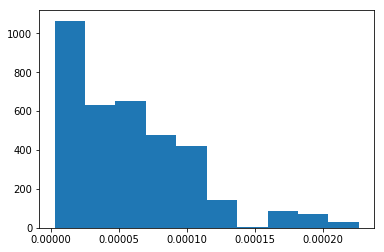

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(posterior_ll)

(array([ 87., 128., 285., 125., 448., 217., 922., 650., 530., 191.]),
 array([-12.76013482, -12.32332152, -11.88650821, -11.44969491,
        -11.0128816 , -10.5760683 , -10.13925499,  -9.70244169,
         -9.26562838,  -8.82881508,  -8.39200177]),
 <a list of 10 Patch objects>)

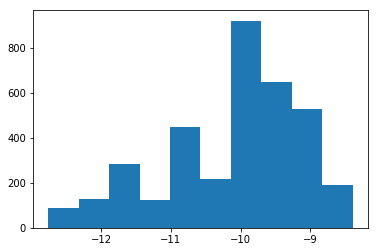

In [25]:
plt.hist(np.log(posterior_ll))

In [26]:
np.log(likelihood(start_state, n)), likelihood(start_state, n)

(-10.555622557558927, 2.6046619768292894e-05)

### average acceptance probability

In [27]:
prob_avg

0.3958253976048061

### sampling for sequence

In [353]:
sequences = []
for i in range(30):
    generate_data(states, coalescent_times)
    sequences.append(deepcopy(states))
# evecs

start_sequence= deepcopy(sequences)

In [355]:
start_sequence

[[['A', 'A'], ['C', 'C'], ['C', 1], ['C', 2], ['A', 4], [3, 5], ['C', 6]],
 [['T', 'C'], ['A', 'T'], ['C', 1], ['C', 2], ['G', 4], [3, 5], ['A', 6]],
 [['T', 'T'], ['C', 'G'], ['A', 1], ['T', 2], ['G', 4], [3, 5], ['T', 6]],
 [['T', 'T'], ['G', 'C'], ['C', 1], ['A', 2], ['T', 4], [3, 5], ['G', 6]],
 [['A', 'A'], ['A', 'A'], ['G', 1], ['A', 2], ['A', 4], [3, 5], ['T', 6]],
 [['G', 'A'], ['G', 'G'], ['G', 1], ['G', 2], ['A', 4], [3, 5], ['C', 6]],
 [['A', 'A'], ['A', 'G'], ['A', 1], ['G', 2], ['A', 4], [3, 5], ['A', 6]],
 [['T', 'T'], ['C', 'C'], ['G', 1], ['T', 2], ['T', 4], [3, 5], ['T', 6]],
 [['C', 'T'], ['G', 'G'], ['T', 1], ['A', 2], ['A', 4], [3, 5], ['G', 6]],
 [['A', 'A'], ['A', 'A'], ['A', 1], ['G', 2], ['A', 4], [3, 5], ['G', 6]],
 [['G', 'T'], ['C', 'T'], ['T', 1], ['T', 2], ['G', 4], [3, 5], ['A', 6]],
 [['C', 'C'], ['C', 'G'], ['C', 1], ['T', 2], ['T', 4], [3, 5], ['A', 6]],
 [['G', 'G'], ['G', 'G'], ['G', 1], ['A', 2], ['G', 4], [3, 5], ['C', 6]],
 [['A', 'A'], ['A', 'A'],

In [356]:
import copy
posterior_sampled = []
n=7 ######n = 8 actually, here n = 7 means that there are 7 coalescent events
prob_avg = 0
sequences = deepcopy(start_sequence)
for i in range(10000):
    if i%1000 == 0:
        print(i)
    prev_sequence = copy.deepcopy(sequences)
    
    state_flag = markov_chain_seq(n+1, sequences)
    while not state_flag:
        state_flag = markov_chain_seq(n+1, sequences)
            
    prev_likelihood = seq_likelihood(prev_sequence, n)
    new_likelihood = seq_likelihood(sequences, n)
    acceptance_prob = min(new_likelihood/prev_likelihood, 1)
    prob_avg += acceptance_prob
    U = np.random.rand()
    if U < acceptance_prob:
        ###accept
        if i > 999:
            posterior_sampled.append(deepcopy(sequences))
        prev_sequence = deepcopy(sequences)
    else:
        sequences = deepcopy(prev_sequence)
prob_avg /= 10000

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [357]:
start_sequence

[[['A', 'A'], ['C', 'C'], ['C', 1], ['C', 2], ['A', 4], [3, 5], ['C', 6]],
 [['T', 'C'], ['A', 'T'], ['C', 1], ['C', 2], ['G', 4], [3, 5], ['A', 6]],
 [['T', 'T'], ['C', 'G'], ['A', 1], ['T', 2], ['G', 4], [3, 5], ['T', 6]],
 [['T', 'T'], ['G', 'C'], ['C', 1], ['A', 2], ['T', 4], [3, 5], ['G', 6]],
 [['A', 'A'], ['A', 'A'], ['G', 1], ['A', 2], ['A', 4], [3, 5], ['T', 6]],
 [['G', 'A'], ['G', 'G'], ['G', 1], ['G', 2], ['A', 4], [3, 5], ['C', 6]],
 [['A', 'A'], ['A', 'G'], ['A', 1], ['G', 2], ['A', 4], [3, 5], ['A', 6]],
 [['T', 'T'], ['C', 'C'], ['G', 1], ['T', 2], ['T', 4], [3, 5], ['T', 6]],
 [['C', 'T'], ['G', 'G'], ['T', 1], ['A', 2], ['A', 4], [3, 5], ['G', 6]],
 [['A', 'A'], ['A', 'A'], ['A', 1], ['G', 2], ['A', 4], [3, 5], ['G', 6]],
 [['G', 'T'], ['C', 'T'], ['T', 1], ['T', 2], ['G', 4], [3, 5], ['A', 6]],
 [['C', 'C'], ['C', 'G'], ['C', 1], ['T', 2], ['T', 4], [3, 5], ['A', 6]],
 [['G', 'G'], ['G', 'G'], ['G', 1], ['A', 2], ['G', 4], [3, 5], ['C', 6]],
 [['A', 'A'], ['A', 'A'],

In [364]:
posterior_sampled[700]

[[['A', 'A'], ['C', 'C'], ['C', 2], ['A', 'C'], [4, 1], ['C', 5], [3, 6]],
 [['T', 'C'], ['C', 'A'], ['T', 2], ['G', 'C'], [4, 1], ['A', 5], [3, 6]],
 [['T', 'T'], ['A', 'C'], ['G', 2], ['G', 'T'], [4, 1], ['T', 5], [3, 6]],
 [['T', 'T'], ['C', 'G'], ['C', 2], ['T', 'A'], [4, 1], ['G', 5], [3, 6]],
 [['A', 'A'], ['G', 'A'], ['A', 2], ['A', 'A'], [4, 1], ['T', 5], [3, 6]],
 [['G', 'A'], ['G', 'G'], ['G', 2], ['A', 'G'], [4, 1], ['C', 5], [3, 6]],
 [['A', 'A'], ['A', 'A'], ['G', 2], ['A', 'G'], [4, 1], ['A', 5], [3, 6]],
 [['T', 'T'], ['G', 'C'], ['C', 2], ['T', 'T'], [4, 1], ['T', 5], [3, 6]],
 [['C', 'T'], ['T', 'G'], ['G', 2], ['A', 'A'], [4, 1], ['G', 5], [3, 6]],
 [['A', 'A'], ['A', 'A'], ['A', 2], ['A', 'G'], [4, 1], ['G', 5], [3, 6]],
 [['G', 'T'], ['T', 'C'], ['T', 2], ['G', 'T'], [4, 1], ['A', 5], [3, 6]],
 [['C', 'C'], ['C', 'C'], ['G', 2], ['T', 'T'], [4, 1], ['A', 5], [3, 6]],
 [['G', 'G'], ['G', 'G'], ['G', 2], ['G', 'A'], [4, 1], ['C', 5], [3, 6]],
 [['A', 'A'], ['T', 'A'],

In [362]:
prob_avg

0.381861474415789

In [365]:
for i in range(10):
    ct = {'A': 0, 'C':0,'G':0,'T':0}
    for state in posterior_sampled[0]:
        for pair in state:
            for val in pair:
                if val in ct:
                    ct[val] += 1
    print(ct)

{'A': 59, 'C': 53, 'G': 66, 'T': 62}
{'A': 59, 'C': 53, 'G': 66, 'T': 62}
{'A': 59, 'C': 53, 'G': 66, 'T': 62}
{'A': 59, 'C': 53, 'G': 66, 'T': 62}
{'A': 59, 'C': 53, 'G': 66, 'T': 62}
{'A': 59, 'C': 53, 'G': 66, 'T': 62}
{'A': 59, 'C': 53, 'G': 66, 'T': 62}
{'A': 59, 'C': 53, 'G': 66, 'T': 62}
{'A': 59, 'C': 53, 'G': 66, 'T': 62}
{'A': 59, 'C': 53, 'G': 66, 'T': 62}


In [366]:
ct = {'A': 0, 'C':0,'G':0,'T':0}
for state in start_sequence:
    for pair in state:
        for val in pair:
            if val in ct:
                ct[val] += 1
ct

{'A': 59, 'C': 53, 'G': 66, 'T': 62}

In [367]:
np.log(seq_likelihood(start_sequence, n))

-317.9072775283018

In [368]:

posterior_ll = []

for seq in posterior_sampled:
    posterior_ll.append(seq_likelihood(seq, n))

(array([  2.,   1.,   6.,  17.,  30.,  46.,  36.,  49.,  53.,  68., 160.,
        261., 352., 400., 550., 417., 235., 311., 226., 200.]),
 array([-325.3936962 , -324.87591188, -324.35812756, -323.84034324,
        -323.32255891, -322.80477459, -322.28699027, -321.76920594,
        -321.25142162, -320.7336373 , -320.21585297, -319.69806865,
        -319.18028433, -318.6625    , -318.14471568, -317.62693136,
        -317.10914703, -316.59136271, -316.07357839, -315.55579407,
        -315.03800974]),
 <a list of 20 Patch objects>)

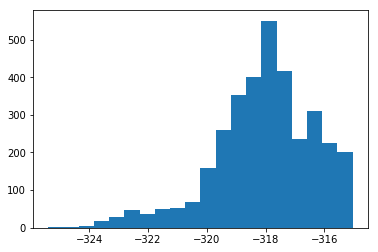

In [369]:
np.mean(posterior_ll)
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(np.log(posterior_ll), bins = 20)

(array([1604.,  674.,  286.,   96.,  133.,   79.,  122.,   61.,   45.,
          95.,   25.,    0.,   11.,   70.,   16.,   22.,    0.,   59.,
           0.,   22.]),
 array([4.82295592e-142, 7.58513297e-139, 1.51654430e-138, 2.27457530e-138,
        3.03260630e-138, 3.79063730e-138, 4.54866831e-138, 5.30669931e-138,
        6.06473031e-138, 6.82276131e-138, 7.58079231e-138, 8.33882331e-138,
        9.09685432e-138, 9.85488532e-138, 1.06129163e-137, 1.13709473e-137,
        1.21289783e-137, 1.28870093e-137, 1.36450403e-137, 1.44030713e-137,
        1.51611023e-137]),
 <a list of 20 Patch objects>)

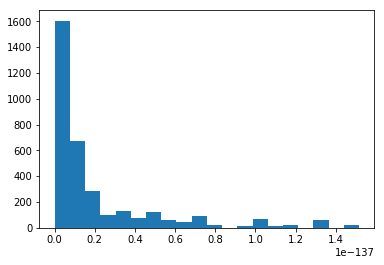

In [370]:
plt.hist(posterior_ll, bins = 20)

In [371]:
seq_likelihood(start_sequence, n)

8.602478830831119e-139

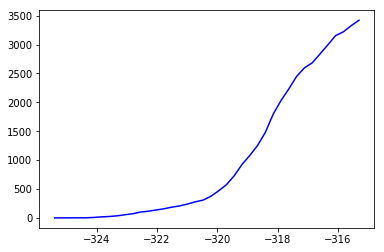

In [372]:
values, base = np.histogram(np.log(posterior_ll), bins=40)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue')

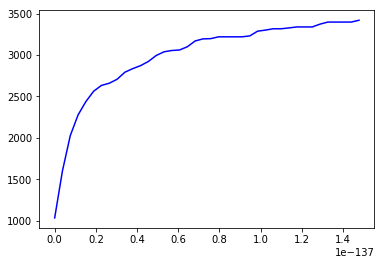

In [373]:
values, base = np.histogram(posterior_ll, bins=40)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue')

In [374]:
np.median(np.log(posterior_ll))

-317.9477637755995

In [375]:
np.median(posterior_ll)

8.261152871156952e-139

In [376]:
np.mean(np.log(posterior_ll))

-318.055259448476

In [323]:
posterior_distribution = {}
for state in posterior_sampled:
    if str(state) not in posterior_distribution:
        posterior_distribution[str(state)] = 1
    else:
        posterior_distribution[str(state)] += 1

In [324]:
len(posterior_distribution.keys())

3846

In [325]:
seq_likelihood(start_sequence, 7)

1.1945359780905916e-47

In [286]:
len(posterior_sampled)

689

In [282]:
sorted(posterior_distribution.items(), key=lambda item: item[1],reverse = True)[0]

("[[['T', 'G'], ['A', 1], ['A', 2], ['A', 'T'], ['G', 4], ['A', 3], [5, 6]], [['G', 'G'], ['A', 'C'], ['G', 'G'], [1, 2], [3, 'C'], [5, 'C'], [4, 6]], [['A', 'A'], [1, 'A'], [2, 'T'], ['A', 'A'], ['G', 3], [4, 'A'], [5, 6]], [['G', 'G'], ['G', 'T'], [1, 2], ['C', 'G'], [3, 4], ['G', 'T'], [5, 6]], [['C', 'C'], ['T', 'A'], ['G', 1], [2, 'A'], ['T', 3], [5, 'A'], [4, 6]], [['G', 'A'], [1, 'T'], ['C', 'T'], [2, 'T'], ['G', 3], [4, 5], ['G', 6]], [['T', 'T'], ['C', 'A'], [1, 'T'], [2, 'T'], ['A', 3], ['T', 5], [4, 6]], [['T', 'G'], ['T', 1], ['C', 'G'], [2, 3], ['G', 'A'], [4, 'G'], [5, 6]], [['C', 'C'], ['T', 1], ['G', 'A'], [2, 3], [4, 'A'], [5, 'T'], ['A', 6]], [['A', 'A'], ['T', 'G'], [2, 'G'], [1, 'G'], [3, 'C'], [5, 4], ['T', 6]], [['T', 'T'], [1, 'T'], [2, 'C'], ['C', 'C'], [3, 4], ['C', 'G'], [5, 6]], [['A', 'A'], ['A', 1], ['T', 'C'], ['A', 2], ['G', 3], [4, 'C'], [5, 6]], [['C', 'C'], ['C', 'T'], ['A', 2], ['T', 'T'], [1, 'T'], [3, 5], [4, 6]], [['C', 'A'], [1, 'T'], ['A', 'A'], 

In [283]:
seq_likelihood([[['T', 'G'], ['A', 1], ['A', 2], ['A', 'T'], ['G', 4], ['A', 3], [5, 6]], [['G', 'G'], ['A', 'C'], ['G', 'G'], [1, 2], [3, 'C'], [5, 'C'], [4, 6]], [['A', 'A'], [1, 'A'], [2, 'T'], ['A', 'A'], ['G', 3], [4, 'A'], [5, 6]], [['G', 'G'], ['G', 'T'], [1, 2], ['C', 'G'], [3, 4], ['G', 'T'], [5, 6]], [['C', 'C'], ['T', 'A'], ['G', 1], [2, 'A'], ['T', 3], [5, 'A'], [4, 6]], [['G', 'A'], [1, 'T'], ['C', 'T'], [2, 'T'], ['G', 3], [4, 5], ['G', 6]], [['T', 'T'], ['C', 'A'], [1, 'T'], [2, 'T'], ['A', 3], ['T', 5], [4, 6]], [['T', 'G'], ['T', 1], ['C', 'G'], [2, 3], ['G', 'A'], [4, 'G'], [5, 6]], [['C', 'C'], ['T', 1], ['G', 'A'], [2, 3], [4, 'A'], [5, 'T'], ['A', 6]], [['A', 'A'], ['T', 'G'], [2, 'G'], [1, 'G'], [3, 'C'], [5, 4], ['T', 6]], [['T', 'T'], [1, 'T'], [2, 'C'], ['C', 'C'], [3, 4], ['C', 'G'], [5, 6]], [['A', 'A'], ['A', 1], ['T', 'C'], ['A', 2], ['G', 3], [4, 'C'], [5, 6]], [['C', 'C'], ['C', 'T'], ['A', 2], ['T', 'T'], [1, 'T'], [3, 5], [4, 6]], [['C', 'A'], [1, 'T'], ['A', 'A'], [2, 'A'], ['A', 3], [4, 'G'], [5, 6]], [['G', 'G'], ['A', 'G'], ['T', 'C'], [1, 'T'], [2, 4], ['A', 3], [5, 6]], [['C', 'C'], ['A', 'T'], ['G', 'G'], [3, 'G'], [2, 4], [5, 'T'], [1, 6]], [['T', 'T'], ['G', 'G'], [2, 'C'], ['A', 3], [4, 1], [5, 'G'], ['C', 6]], [['G', 'A'], ['G', 'G'], ['T', 'T'], [2, 'C'], [3, 4], [5, 1], ['T', 6]], [['C', 'C'], ['C', 'C'], [2, 'T'], ['G', 3], [1, 'T'], [4, 5], ['G', 6]], [['C', 'C'], ['A', 'A'], [2, 1], ['T', 3], ['T', 'C'], ['A', 5], [4, 6]]], 7)

8.958743873643202e-93

In [146]:
likelihood([['A', 'G'], ['G', 'G'], ['G', 1], ['T', 2], ['C', 4], [3, 5], ['G', 6]], 7)

1.0672997341361499e-05

In [147]:
likelihood([['G', 'G'], ['G', 'G'], [2, 'G'], ['A', 3], ['T', 'C'], [1, 4], [5, 6]], 7)

0.00011566432806316471

In [178]:
prior_sampled = []
states = [['G', 'G'],['C', 'A'], ['C', 1], ['C', 2], ['A', 4], [3,5], ['A', 6]]
coalescent_times = [.2,.5,.6,.8,1.3,1.9,2.9]
for i in range(7707):
    prev_state = copy.deepcopy(states)
    prior_sampled.append(prev_state)
    state_flag = markov_chain_forward(n+1,states)
    while not state_flag:
        state_flag = markov_chain_forward(n+1,states)
    

In [182]:
posterior_ll = []
ct = 0
for tree in posterior_sampled:
    ct += 1
    posterior_ll.append(likelihood(tree, 7))
    if ct %1000==0:
        print(ct//1000, 'iter_')

1 iter_
2 iter_
3 iter_
4 iter_
5 iter_
6 iter_
7 iter_


In [183]:
prior_ll = []
for tree in prior_sampled:
    prior_ll.append(likelihood(tree, 7))


In [184]:
posterior_ll = np.array(posterior_ll)
prior_ll = np.array(prior_ll)

Text(0.5,0,'log likelihood')

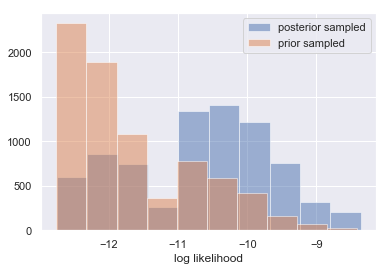

In [190]:
import seaborn as sns
sns.set()
plt.hist(np.log(posterior_ll),alpha = .5, label = 'posterior sampled')
plt.hist(np.log(prior_ll), alpha = .5, label = 'prior sampled')
plt.legend()
plt.xlabel('log likelihood')

In [200]:
states = [['G', 'G'],['C', 'A'], ['C', 1], ['C', 2], ['A', 4], [3,5], ['A', 6]]
print(np.log(likelihood(states, 7)))

-10.555622557558927


In [203]:
np.log(likelihood(posterior_sampled[np.argmax(posterior_ll)], 7))

-8.354450743754589

In [204]:
posterior_sampled[np.argmax(posterior_ll)]

[['A', 'A'], ['A', 1], ['C', 'C'], [3, 'C'], ['G', 'G'], [5, 4], [2, 6]]

In [ ]:
states = [['G', 'G'],['C', 'A'], ['C', 1], ['C', 2], ['A', 4], [3,5], ['A', 6]]

In [205]:
coalescent_times
###fix coalescent time, fix tree, simulation the data

[0.2, 0.5, 0.6, 0.8, 1.3, 1.9, 2.9]

In [213]:
q

array([[-1.        ,  0.33333333,  0.33333333,  0.33333333],
       [ 0.33333333, -1.        ,  0.33333333,  0.33333333],
       [ 0.33333333,  0.33333333, -1.        ,  0.33333333],
       [ 0.33333333,  0.33333333,  0.33333333, -1.        ]])

In [215]:
Pij(1, evecs, evals,evec_inv)

array([[0.44769785, 0.18410072, 0.18410072, 0.18410072],
       [0.18410072, 0.44769785, 0.18410072, 0.18410072],
       [0.18410072, 0.18410072, 0.44769785, 0.18410072],
       [0.18410072, 0.18410072, 0.18410072, 0.44769785]])

### variational using the prior distance function
### using swapping markov chain, (run again or improve time efficiency) TODO..
### getting stuck and sampling


#### starting about thinking branch length , hmc etc.. (gradients on branch length), marginalized on branch length (variational inference relying on automatic differentiation) another latent layer (one layer is effective population size, one layer is coalescent time)

gradient for coalescent time and likelihood
biggest problem for HMC, tree is easy to construct. cannot propose to have negative branch length (one proposal increasing decreasing branch length (negative branch length)), parmaterice increment. keep step size of Hamiltonian.

problem to compute the gradient, they use estimate of gradient, and improve the estimation. 
out win a problem that cannot compute the gradient

black-box 
simulated annealling, distance, exponential

doing greedy search

fixed unlabelled tree, uniformly labelling
distribution on = distribution of unlabelled * uniform
MCMC (save likelihood and posterior at each iteration)


In [199]:
np.log(np.mean(posterior_ll))

-10.21916362447655

In [1]:
import numpy as np

In [356]:
# (145*4*1.16+100)/4

193.2

In [359]:
# (135*4*1.20+137.5)/4

196.375

MCMC()
###simulate data from the model, fix one tree, simulate data, compute the likelihood of different trees, hopefully convex function, with a peak on the simulated trees.

have a tree, needs to compute transition probability

matrix exponential, conditional on time, look at the corresponding row to
sample multinomial by row value

simulate with a lot of possible mutations (high mutation rate).
